In [1]:
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
from PIL.BmpImagePlugin import BmpImageFile

plt.rc('figure', figsize=(20.0, 10.0))

In [3]:
def load_image_into_numpy_array(image: BmpImageFile) -> np.array:
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width)).astype(np.float64)

In [4]:
x_image = Image.open('x2.bmp')
X = load_image_into_numpy_array(x_image)
X = np.vstack((X, np.ones(X.shape[1])))

y_image = Image.open('y2.bmp')
Y = load_image_into_numpy_array(y_image)

In [5]:
def Greville(X: np.array) -> np.array:
    vec = X[0].reshape(-1, 1)
    eps = np.float32(1e-9)

    if np.abs(np.dot(vec.T, vec).item()) < eps:
        X_pseudo_inv = vec
    else:
        X_pseudo_inv = vec / np.dot(vec.T, vec).item()

    eps = 1e-9
    n_rows, n_columns = X.shape

    for i in range(1, n_rows):
        vec = X[i].reshape(-1, 1)
        Z = np.eye(n_columns) - X_pseudo_inv @ X[:i]
        norm = np.dot(np.dot(vec.T, Z), vec).item()
        if np.abs(norm) < eps:
            Z = X_pseudo_inv @ X_pseudo_inv.T
            norm = np.dot(np.dot(vec.T, Z), vec).item() + 1.
        X_pseudo_inv -= np.dot(np.dot(np.dot(Z, vec), vec.T), X_pseudo_inv) / norm
        X_pseudo_inv = np.column_stack((X_pseudo_inv, (np.dot(Z, vec) / norm)))

    return X_pseudo_inv

In [6]:
def Moore_Penrose(X: np.array) -> np.array:
    def pseudo_inv(X: np.array, delta: float) -> np.array:
        n_rows, n_columns = X.shape
        if n_rows > n_columns:
            X_inv = np.linalg.inv(X.T @ X - (delta ** 2 * np.eye(n_columns))) @ X.T
        else:
            X_inv = X.T @ np.linalg.inv(X @ X.T - (delta ** 2 * np.eye(n_rows)))
        return X_inv

    delta = 100
    eps = 1e-12
    diff = 1

    while diff > eps:
        X_inv_1 = pseudo_inv(X, delta)
        delta /= 2.
        X_inv_2 = pseudo_inv(X, delta)
        diff = np.linalg.norm(X_inv_1 - X_inv_2)

    return X_inv_1

In [7]:
Grev_X = Greville(X)
Moore_X = Moore_Penrose(X)

In [8]:
Z_grev = np.eye(X.shape[0]) - X @ Grev_X
Z_Moore = np.eye(X.shape[0]) - X @ Moore_X
Z_Moore_python = np.eye(X.shape[0]) - X @ np.linalg.pinv(X)

V = np.random.rand(Y.shape[0], Grev_X.shape[1])
A_Grev = Y @ Grev_X + V @ Z_grev.T
A_Moore = Y @ Moore_X + V @ Z_Moore.T
A_Moore_python = Y @ np.linalg.pinv(X) + V @ Z_Moore_python.T

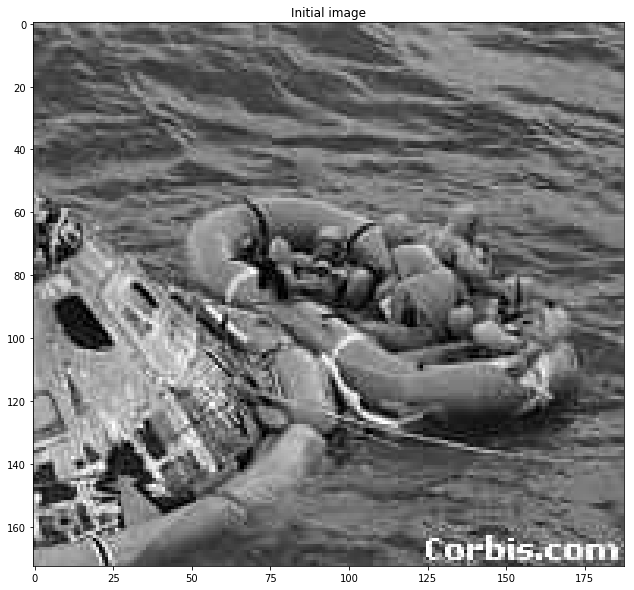

In [9]:
fig, ax = plt.subplots(1)
ax.set_title('Initial image')
ax.imshow(y_image);

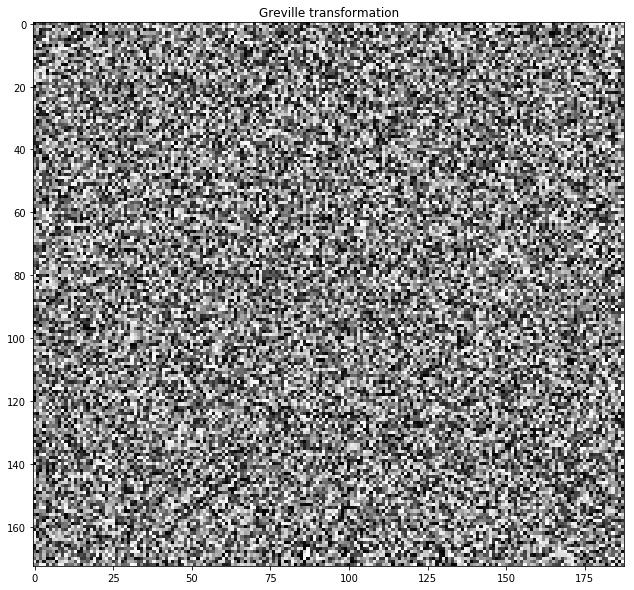

In [10]:
Y_Grev = A_Grev @ X
y_image_Grev = Image.fromarray(Y_Grev.astype(np.uint8), mode='L')
fig, ax = plt.subplots(1)
ax.set_title('Greville transformation')
ax.imshow(y_image_Grev);

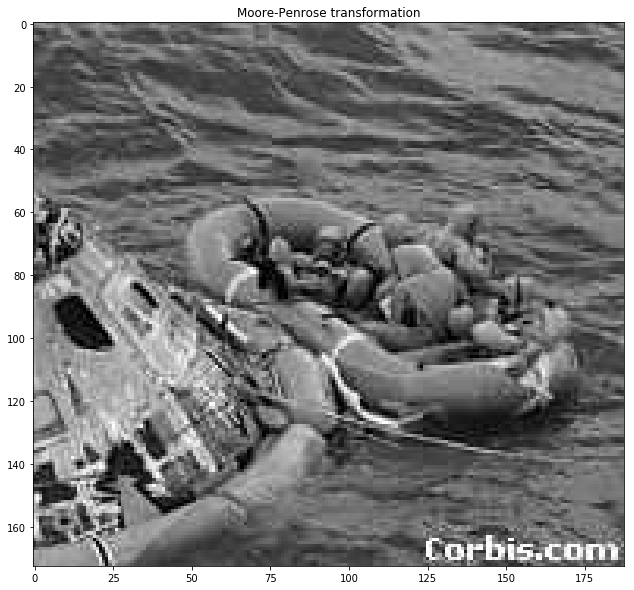

In [11]:
Y_Moore = A_Moore @ X
y_image_Moore = Image.fromarray(Y_Moore.astype(np.uint8), mode='L')
fig, ax = plt.subplots(1)
ax.set_title('Moore-Penrose transformation')
ax.imshow(y_image_Moore);

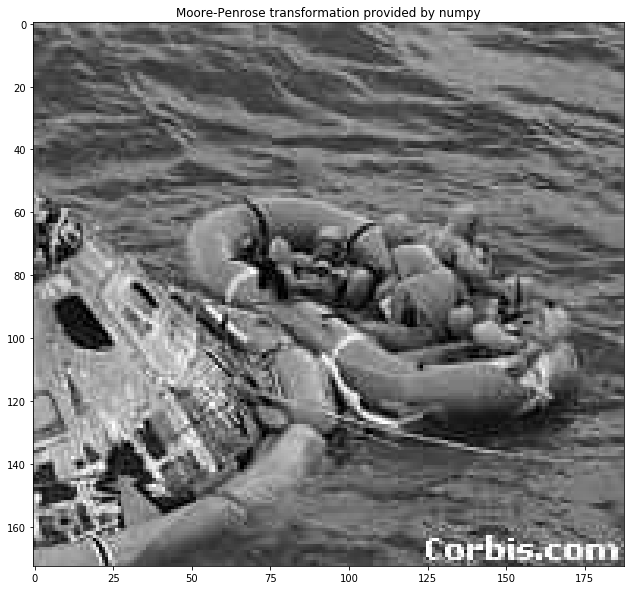

In [12]:
Y_Moore_python = A_Moore_python @ X
y_image_Moore_python = Image.fromarray(Y_Moore_python.astype(np.uint8), mode='L')
fig, ax = plt.subplots(1)
ax.set_title('Moore-Penrose transformation provided by numpy')
ax.imshow(y_image_Moore_python);